# <center><u><font color='red'>Titanic - Machine Learning from Disaster 2</font></u></center>

## <font color='green'>Mise en place de l'environnement de travail</font>

In [432]:
# import packages

import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
import time
import random
#from time import time

from sklearn.metrics import mean_squared_error
from math import sqrt

pd.options.mode.chained_assignment = None

#import library
import scipy.stats as stats
from scipy.stats.stats import pearsonr

from sklearn import model_selection
from sklearn import neighbors, metrics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

#Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC  #Support Vector Classifier

pd.options.display.width = 0

from termcolor import colored

In [433]:
def classification(best_param,
                   X_train,
                   y_train,
                   X_test,
                   y_test,
                   algo_name,
                   index,
                   file_name=None):
    
    """This function execute a cla"""
    print(colored("Exécution \n ", 'red'))

    start_time = time.time()
    model = best_param.fit(X_train, y_train)
    execution_time = (time.time() - start_time)

    if file_name is None:
        pass
    else:
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    start_time = time.time()
    prediction = best_param.predict(X_test)
    prediction_time = (time.time() - start_time)

    # prediction de probabilité d'appartenance à 0 et 1
    probability = best_param.predict_proba(X_test)
    probability_positive = probability[:, 1]

    resume_prediction_class = pd.DataFrame({
        'cat_reel': y_test,
        'cat_predit': prediction
    }).reset_index()

    print(resume_prediction_class)

    probability_positive_class = pd.DataFrame({
        'PassengerId': index,
        'positive_probability':  #probabilité d'être 1 et donc de survivre
        probability_positive
    })

    print(probability_positive_class)

    print(colored("Qualité de la classification \n \n ", 'red'))
    accuracy = accuracy_score(y_test, prediction)
    print(
        colored(
            'L\'accuracy score est de {} pour la méthode {}.\n \n '.format(
                accuracy, algo_name), 'blue'))

    # binary car ici 0 ou 1 si plusieurs label c'est weighted
    precision = precision_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score de précision est de {} pour la méthode {}.\n \n '.format(
                precision, algo_name), 'blue'))

    recall = recall_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score recall est de {} pour la méthode {}.\n \n '.format(
                recall, algo_name), 'blue'))

    f1 = f1_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score f1 est de {} pour la méthode {}.\n \n '.format(
                f1, algo_name), 'blue'))

    # proba de na pas rembourser prêt donc d'être 1
    AUC = roc_auc_score(y_test, probability[:, 1])
    print(
        colored(
            'Le score AUC est de {} pour la méthode {}.\n \n '.format(
                AUC, algo_name), 'blue'))

    return model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class

In [434]:
def matrix_TN_FN(y_test, y_prediction):
    """
    Cette fonction retourne une matrice de confusion.
    """

    # Création de la matrice de confusion.
    df_matrice_confusion = pd.DataFrame(
        columns=['Predicted Negative (0)', 'Predicted Positive (1)'],
        index=['Real Negative (0)', 'Real Positive (1)'])

    # DataFrame de comparaison.
    df_pred_compare = pd.concat(
        [pd.Series(y_test.reset_index(drop=True)),
         pd.Series(y_prediction)],
        axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']

    # Masque suivant les tp,tn, fp...
    mask_real_pos = (df_pred_compare['Real category'] == 1)
    mask_pred_pos = (df_pred_compare['Prediction'] == 1)

    mask_real_neg = (df_pred_compare['Real category'] == 0)
    mask_pred_neg = (df_pred_compare['Prediction'] == 0)

    # Négatif.
    true_negative = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Positif.
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice.
    df_matrice_confusion['Predicted Negative (0)'] = [
        "{} (TN)".format(true_negative), "{} (FN)".format(false_negative)
    ]
    df_matrice_confusion['Predicted Positive (1)'] = [
        "{} (FP)".format(false_positive), "{} (TP)".format(true_positive)
    ]

    return df_matrice_confusion

In [435]:
def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=size)

    # plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    cf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    group_names = [
        'True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)'
    ]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value)
        for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]

    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both',
                    which='major',
                    labelsize=10,
                    labelbottom=False,
                    bottom=False,
                    top=False,
                    labeltop=True)

    # plt.subplot(222)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    # pour la courbe ROC utilisation de la probabiilité d'être 1
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    plt.plot(fpr,
             tpr,
             color='pink',
             linewidth=5,
             label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()

    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    return tn, fp, fn, tp

In [436]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

train = pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [437]:
"""train= pd.read_csv('train_cleaned.csv') #'../input/train-cleaned/train_cleaned.csv'
train = train.set_index("PassengerId")
train"""

'train= pd.read_csv(\'train_cleaned.csv\') #\'../input/train-cleaned/train_cleaned.csv\'\ntrain = train.set_index("PassengerId")\ntrain'

In [438]:
#test= pd.read_csv('test_cleaned.csv')   #../input/test-cleaned/test_cleaned.csv
#test = test.set_index("PassengerId")
#test

 ## <font color='green'>Scale and Transform data</font>

In [439]:
X = train.drop('Survived', axis=1)
Y = train['Survived']

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=42)

In [441]:
train_index = X_train.index
test_index = X_test.index

In [442]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [443]:
X_test

array([[ 0.82100933, -0.99815887,  1.32879933, ...,  0.85374478,
        -0.07559289, -0.14450492],
       [-1.58728471,  0.59040921,  0.42583145, ...,  0.85374478,
        -0.07559289, -0.14450492],
       [ 0.82100933,  0.06088651,  0.42583145, ..., -1.17131023,
        -0.07559289, -0.14450492],
       ...,
       [-1.58728471,  0.43911701,  0.42583145, ..., -1.17131023,
        -0.07559289, -0.14450492],
       [ 0.82100933, -0.31734398,  0.42583145, ...,  0.85374478,
        -0.07559289, -0.14450492],
       [ 0.82100933, -0.01475959, -0.47713644, ...,  0.85374478,
        -0.07559289, -0.14450492]])

## <font color='green'>KNeighborsClassifier = Knn</font>

In [444]:
knn = KNeighborsClassifier(
    n_neighbors=18, weights='uniform',
    algorithm='auto')  #Weight penser si il y a déséquilibre

In [445]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    knn,
    X_train,
    y_train,
    X_test,
    y_test,
    "All_cols - knn",
    test_index,
    file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           1
3            319         1           1
4            217         1           0
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.111111
1            249              0.222222
2            800              0.611111
3            319              0.944444
4            217              0.500000
..           ...                   ...
171          587              0.000000
172          241              0.611111
173          487              1.000000
174          354              0.166667
175           82              0.111111

[176 rows x 2 columns]
Qua

In [446]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),97 (TN),13 (FP)
Real Positive (1),24 (FN),42 (TP)


In [447]:
roc_auc = roc_auc_score(
    y_test, probability[:, 1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8708
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.76      0.64      0.69        66

    accuracy                           0.79       176
   macro avg       0.78      0.76      0.77       176
weighted avg       0.79      0.79      0.79       176



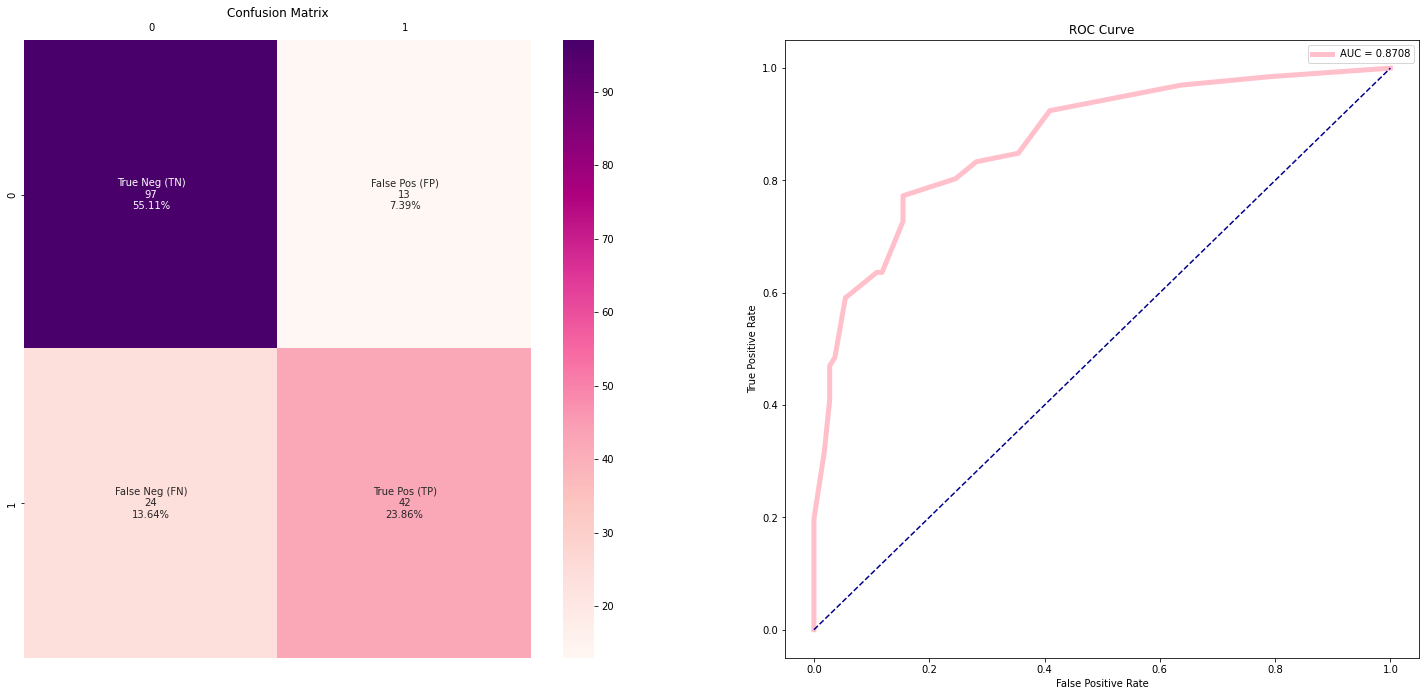

True negative =  97
False positive =  13
False negative =  24
True positive =  42


In [448]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [449]:
comparison_baseline = pd.DataFrame({})

comparison_baseline = comparison_baseline.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - knn",
            "Accuracy": accuracy,
            "AUC": AUC,
            "Recall class 1": recall,
            "F1": f1,
            "TP": tp,
            "Precision": precision,
            "FN": fn,
            "time": prediction_time
        },
        index=[1],
    ))

comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - knn,0.789773,0.870799,0.636364,0.694215,42,0.763636,24,0.013899


## <font color='green'>RandomForestClassifier</font>

In [450]:
Rfc = RandomForestClassifier(n_estimators=50,
                             criterion='gini',
                             max_depth=21,
                             min_samples_split=3,
                             min_samples_leaf=7,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=None,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0.0,
                             max_samples=None)

In [451]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    Rfc,
    X_train,
    y_train,
    X_test,
    y_test,
    "All_cols - Rfc",
    test_index,
    file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           1
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.119711
1            249              0.223844
2            800              0.586807
3            319              0.924907
4            217              0.568225
..           ...                   ...
171          587              0.095425
172          241              0.680059
173          487              0.965843
174          354              0.145415
175           82              0.175970

[176 rows x 2 columns]
Qua

In [452]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),93 (TN),17 (FP)
Real Positive (1),19 (FN),47 (TP)


In [453]:
roc_auc = roc_auc_score(
    y_test, probability[:, 1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8598
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.73      0.71      0.72        66

    accuracy                           0.80       176
   macro avg       0.78      0.78      0.78       176
weighted avg       0.79      0.80      0.79       176



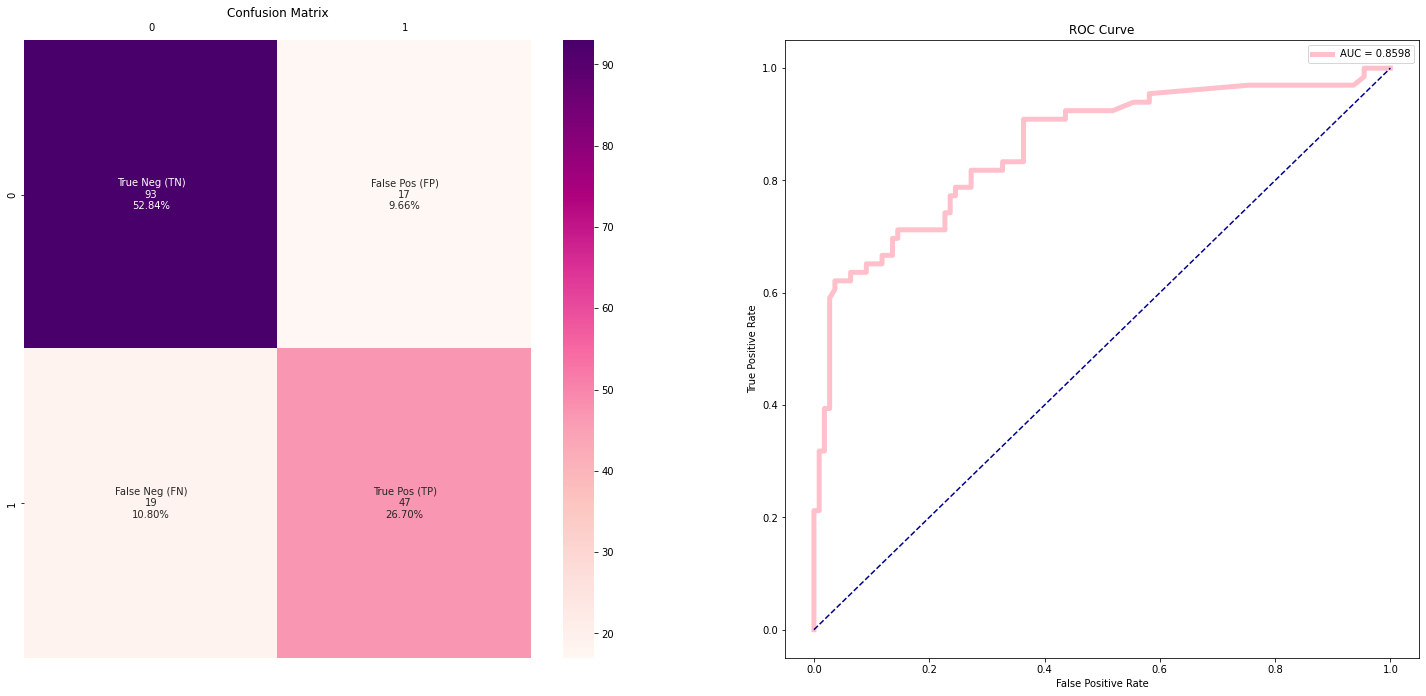

True negative =  93
False positive =  17
False negative =  19
True positive =  47


In [454]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [455]:
comparison_baseline = comparison_baseline.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - Rfc",
            "Accuracy": accuracy,
            "AUC": AUC,
            "Recall class 1": recall,
            "F1": f1,
            "TP": tp,
            "Precision": precision,
            "FN": fn,
            "time": prediction_time
        },
        index=[2],
    ))

comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - knn,0.789773,0.870799,0.636364,0.694215,42,0.763636,24,0.013899
2,All_cols - Rfc,0.795455,0.859780,0.712121,0.723077,47,0.734375,19,0.006647


## <font color='green'>SVC</font>

In [456]:
SVC = SVC(C=0.53, kernel='linear', gamma=0.01, probability=True)

In [457]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    SVC,
    X_train,
    y_train,
    X_test,
    y_test,
    "All_cols - SVC",
    test_index,
    file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           1
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.054628
1            249              0.099749
2            800              0.779920
3            319              0.780248
4            217              0.780121
..           ...                   ...
171          587              0.181200
172          241              0.643080
173          487              0.780563
174          354              0.099628
175           82              0.181116

[176 rows x 2 columns]
Qua

In [458]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),94 (TN),16 (FP)
Real Positive (1),19 (FN),47 (TP)


In [459]:
roc_auc = roc_auc_score(
    y_test, probability[:, 1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8019
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.71      0.73        66

    accuracy                           0.80       176
   macro avg       0.79      0.78      0.79       176
weighted avg       0.80      0.80      0.80       176



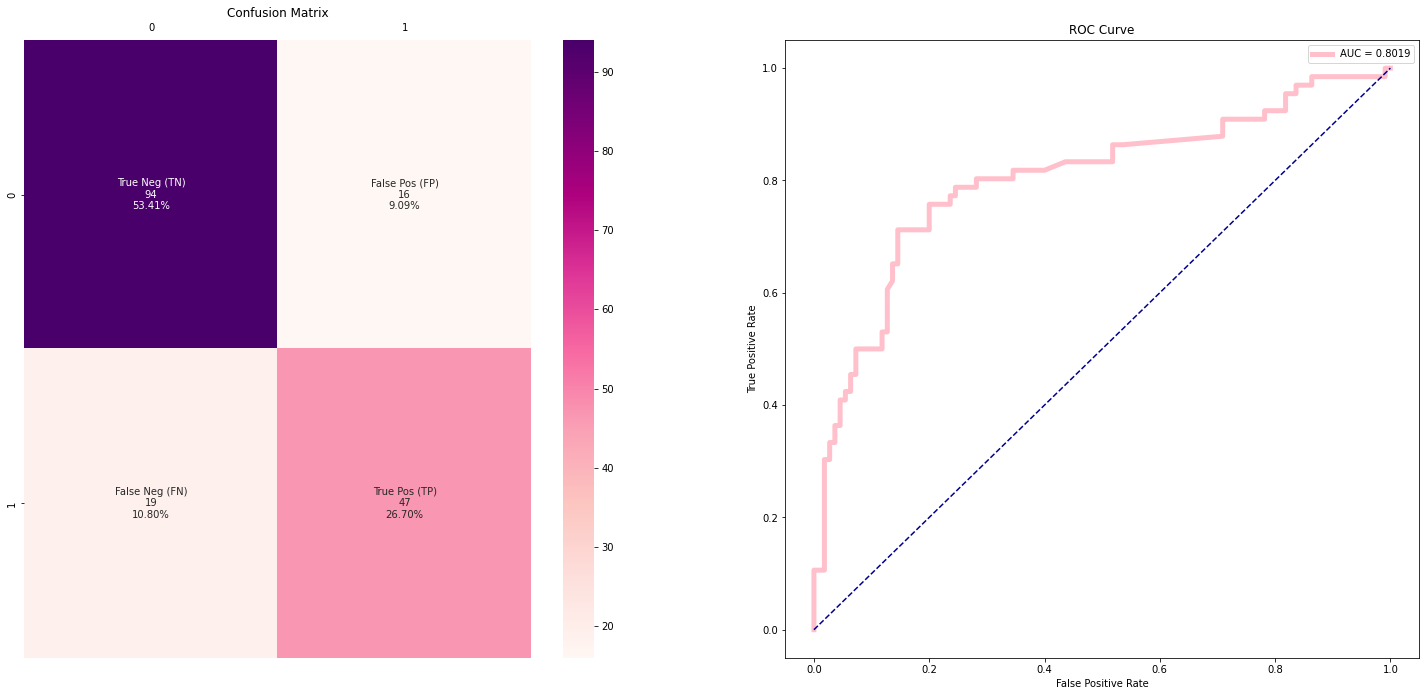

True negative =  94
False positive =  16
False negative =  19
True positive =  47


In [460]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [461]:
comparison_baseline = comparison_baseline.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - SVC",
            "Accuracy": accuracy,
            "AUC": AUC,
            "Recall class 1": recall,
            "F1": f1,
            "TP": tp,
            "Precision": precision,
            "FN": fn,
            "time": prediction_time
        },
        index=[3],
    ))

comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - knn,0.789773,0.870799,0.636364,0.694215,42,0.763636,24,0.013899
2,All_cols - Rfc,0.795455,0.859780,0.712121,0.723077,47,0.734375,19,0.006647
3,All_cols - SVC,0.801136,0.801928,0.712121,0.728682,47,0.746032,19,0.001579


## <font color='green'>LGBMClassifier</font>

In [462]:
def algorithm_pipeline(X_train_data,
                       X_test_data,
                       y_train_data,
                       y_test_data,
                       model,
                       param_grid,
                       cv=10,
                       scoring_fit='neg_mean_squared_error',
                       do_probabilities=False):
    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      cv=cv,
                      n_jobs=-1,
                      scoring=scoring_fit,
                      verbose=2)

    #gs = GridSearchCV(
    #model,
    #param_grid = param_grid,
    #cv=cv,
    #n_jobs=-1,
    #scoring=scoring_fit,
    #verbose=2)

    #gs = RandomizedSearchCV(
    #estimator=model,
    #param_distributions=param_grid,
    #cv=cv,
    #n_jobs=-1,
    #scoring=scoring_fit,
    #verbose=2)

    #GridSearchCV
    fitted_model = gs.fit(X_train_data, y_train_data)

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [463]:
lgbm = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      num_class=9,
                      early_stopping=50,
                      num_iteration=10000,
                      num_leaves=200,
                      is_enable_sparse='true',
                      tree_learner='data',
                      min_data_in_leaf=600,
                      max_depth=25,
                      learning_rate=0.01,
                      n_estimators=400,
                      max_bin=255,
                      subsample_for_bin=50000,
                      min_split_gain=0.3,
                      min_child_weight=5,
                      min_child_samples=10,
                      subsample=0.995,
                      subsample_freq=20,
                      colsample_bytree=0.8,
                      reg_alpha=1.3,
                      reg_lambda=1.1,
                      seed=0,
                      nthread=-1,
                      silent=True)

In [464]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

In [465]:
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'  #GradientBoostingDecisionTree
params['objective'] = 'binary'  #Binary target feature
params['metric'] = 'binary_logloss'  #metric for binary classification
params['max_depth'] = 10

In [466]:
clf = lgb.train(params, d_train, 100)  #train the model on 100 epocs

In [467]:
def classification_lgbm(best_param,
                        X_train,
                        y_train,
                        X_test,
                        y_test,
                        algo_name,
                        index,
                        file_name=None):
    print(colored("Exécution \n ", 'red'))

    start_time = time.time()
    pre_prediction = best_param.predict(X_test)  #.tolist()
    prediction_time = (time.time() - start_time)

    prediction = []

    for i in pre_prediction:
        if i > 0.5:
            prediction.append(1)
        else:
            prediction.append(0)

    resume_prediction_class = pd.DataFrame({
        'cat_reel': y_test,
        'cat_predit': prediction
    }).reset_index()

    print(resume_prediction_class)

    print(colored("Qualité de la classification \n \n ", 'red'))
    accuracy = accuracy_score(y_test, prediction)
    print(
        colored(
            'L\'accuracy score est de {} pour la méthode {}.\n \n '.format(
                accuracy, algo_name), 'blue'))

    # binary car ici 0 ou 1 si plusieurs label c'est weighted
    precision = precision_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score de précision est de {} pour la méthode {}.\n \n '.format(
                precision, algo_name), 'blue'))

    recall = recall_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score recall est de {} pour la méthode {}.\n \n '.format(
                recall, algo_name), 'blue'))

    f1 = f1_score(y_test, prediction, average='binary')
    print(
        colored(
            'Le score f1 est de {} pour la méthode {}.\n \n '.format(
                f1, algo_name), 'blue'))

    # proba de na pas rembourser prêt donc d'être 1
    AUC = roc_auc_score(y_test, probability[:, 1])
    print(
        colored(
            'Le score AUC est de {} pour la méthode {}.\n \n '.format(
                AUC, algo_name), 'blue'))

    return model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class

In [468]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification_lgbm(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    "All_cols - lgbm",
    test_index,
    file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           1
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.7954545454545454 pour la méthode All_cols - lgbm.
 
 
Le score de précision est de 0.7678571428571429 pour la méthode All_cols - lgbm.
 
 
Le score recall est de 0.6515151515151515 pour la méthode All_cols - lgbm.
 
 
Le score f1 est de 0.7049180327868853 pour la méthode All_cols - lgbm.
 
 
Le score AUC est de 0.8019283746556475 pour la méthode All_cols - lgbm.
 
 


In [469]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),97 (TN),13 (FP)
Real Positive (1),23 (FN),43 (TP)


In [470]:
roc_auc = roc_auc_score(
    y_test, probability[:, 1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8019
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.77      0.65      0.70        66

    accuracy                           0.80       176
   macro avg       0.79      0.77      0.77       176
weighted avg       0.79      0.80      0.79       176



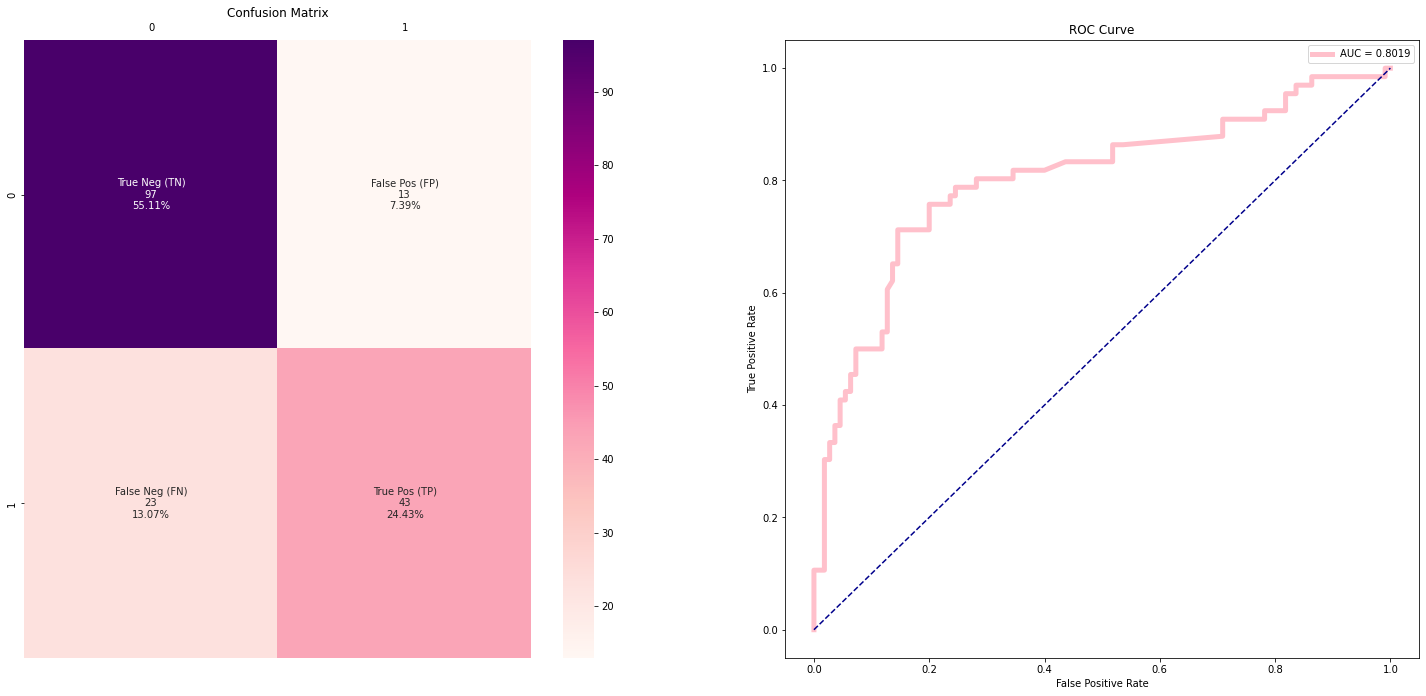

True negative =  97
False positive =  13
False negative =  23
True positive =  43


In [471]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [472]:
comparison_baseline = comparison_baseline.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - lgbm",
            "Accuracy": accuracy,
            "AUC": AUC,
            "Recall class 1": recall,
            "F1": f1,
            "TP": tp,
            "Precision": precision,
            "FN": fn,
            "time": prediction_time
        },
        index=[4],
    ))

comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - knn,0.789773,0.870799,0.636364,0.694215,42,0.763636,24,0.013899
2,All_cols - Rfc,0.795455,0.859780,0.712121,0.723077,47,0.734375,19,0.006647
3,All_cols - SVC,0.801136,0.801928,0.712121,0.728682,47,0.746032,19,0.001579
4,All_cols - lgbm,0.795455,0.801928,0.651515,0.704918,43,0.767857,23,0.001536


## <font color='green'>XGBClassifier</font>

In [473]:
XGBC = XGBClassifier(base_score=0.5,
                     colsample_bylevel=1,
                     colsample_bytree=1,
                     gamma=0,
                     learning_rate=0.1,
                     max_delta_step=0,
                     max_depth=10,
                     min_child_weight=1,
                     missing=1,
                     n_estimators=100,
                     nthread=-1,
                     reg_alpha=0,
                     reg_lambda=1,
                     objective='binary:logistic',
                     scale_pos_weight=1,
                     seed=0,
                     subsample=1,
                     use_label_encoder=False,
                     eval_metric='mlogloss')

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [474]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC,
    X_train,
    y_train,
    X_test,
    y_test,
    "All_cols - XGBC",
    test_index,
    file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.041729
1            249              0.165816
2            800              0.295705
3            319              0.985400
4            217              0.699019
..           ...                   ...
171          587              0.031991
172          241              0.910017
173          487              0.997236
174          354              0.222955
175           82              0.242440

[176 rows x 2 columns]
Qua

In [475]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),98 (TN),12 (FP)
Real Positive (1),19 (FN),47 (TP)


In [476]:
roc_auc = roc_auc_score(
    y_test, probability[:, 1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' % roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8521
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.80      0.71      0.75        66

    accuracy                           0.82       176
   macro avg       0.82      0.80      0.81       176
weighted avg       0.82      0.82      0.82       176



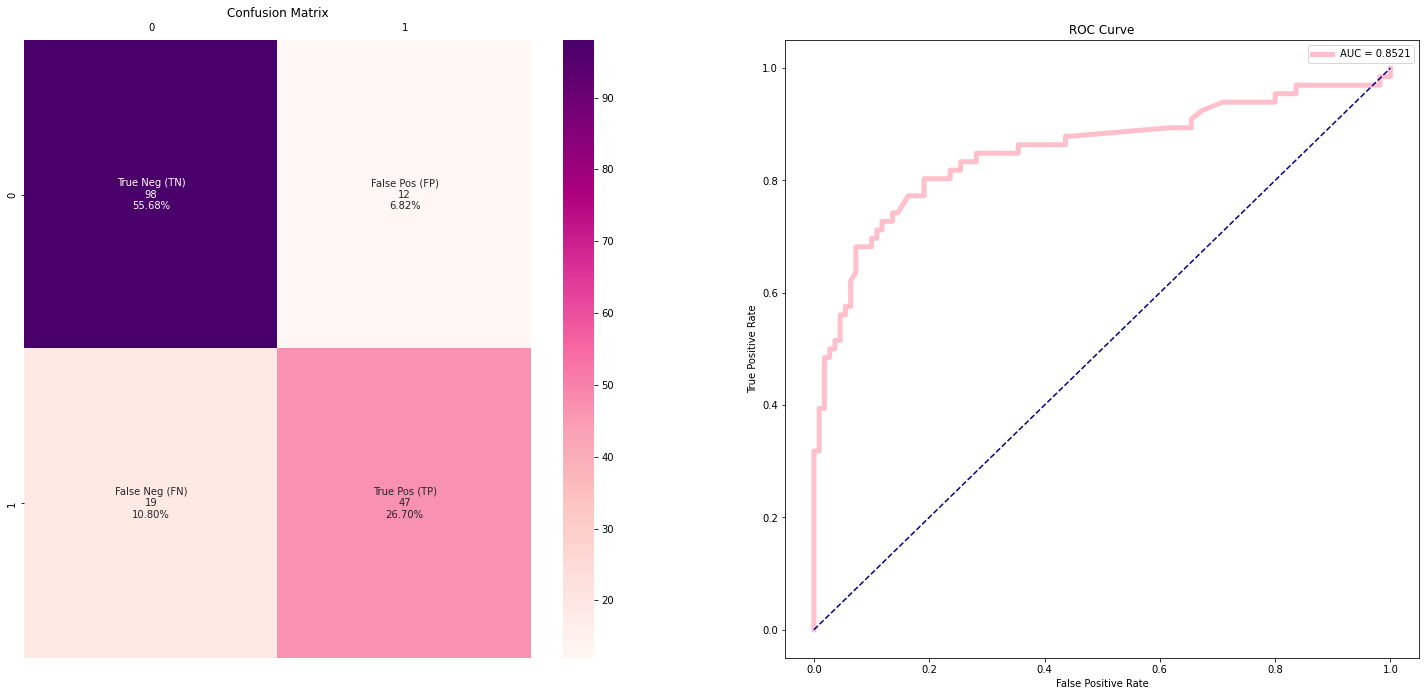

True negative =  98
False positive =  12
False negative =  19
True positive =  47


In [477]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [478]:
comparison_baseline = comparison_baseline.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - XGBC",
            "Accuracy": accuracy,
            "AUC": AUC,
            "Recall class 1": recall,
            "F1": f1,
            "TP": tp,
            "Precision": precision,
            "FN": fn,
            "time": prediction_time
        },
        index=[5],
    ))

comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - knn,0.789773,0.870799,0.636364,0.694215,42,0.763636,24,0.013899
2,All_cols - Rfc,0.795455,0.859780,0.712121,0.723077,47,0.734375,19,0.006647
3,All_cols - SVC,0.801136,0.801928,0.712121,0.728682,47,0.746032,19,0.001579
4,All_cols - lgbm,0.795455,0.801928,0.651515,0.704918,43,0.767857,23,0.001536
5,All_cols - XGBC,0.823864,0.852066,0.712121,0.752000,47,0.796610,19,0.001889


In [479]:
comparison_baseline.to_csv("comparison_baseline.csv", index=False)

## <font color='green'>Rôle de l'âge dans la prédiction de la survie : Modèle moins performant sans cette variable</font>

In [480]:
comparison_age = pd.DataFrame({})

comparison_age = comparison_age.append(
    pd.DataFrame(
        {
            "Modele": "All_cols - XGBC",
            "Accuracy": 0.823864,
            "AUC": 0.852066,
            "Recall class 1": 0.712121,
            "F1": 0.752000,
            "TP": 47,
            "Precision": 0.796610,
            "FN": 19,
            "time": 0.002130
        },
        index=[1],
    ))

In [481]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'	   gender_submission.csv   train_cleaned.csv
 comparison_baseline.csv   prediction.csv
 finalized_model.sav	   test_cleaned.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [482]:
X = train.drop(['Survived', 'Age'],axis=1)
Y = train['Survived']

In [483]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [484]:
train_index = X_train.index
test_index = X_test.index

In [485]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [486]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [487]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_age - XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.035093
1            249              0.084061
2            800              0.382234
3            319              0.951011
4            217              0.599934
..           ...                   ...
171          587              0.104669
172          241              0.540040
173          487              0.989347
174          354              0.128025
175           82              0.119596

[176 rows x 2 columns]
Qua

In [488]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),93 (TN),17 (FP)
Real Positive (1),21 (FN),45 (TP)


In [489]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8069
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.73      0.68      0.70        66

    accuracy                           0.78       176
   macro avg       0.77      0.76      0.77       176
weighted avg       0.78      0.78      0.78       176



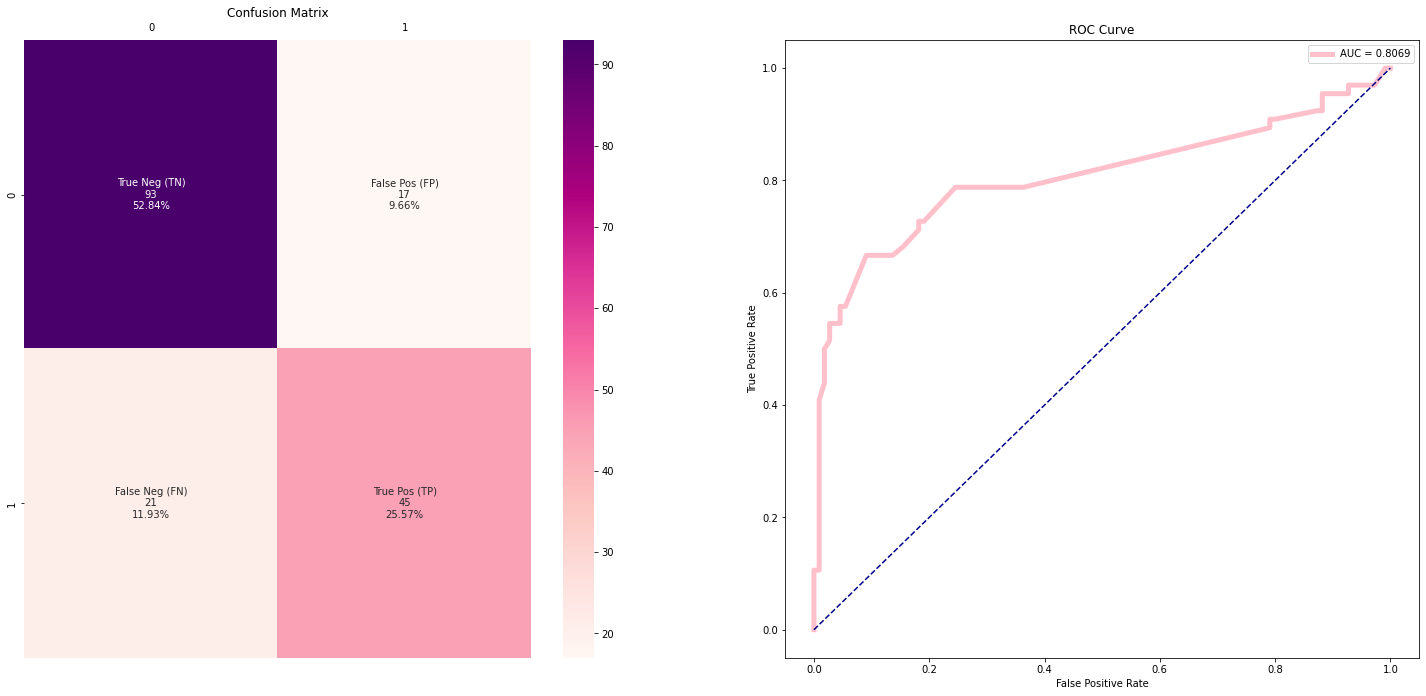

True negative =  93
False positive =  17
False negative =  21
True positive =  45


In [490]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [491]:
comparison_age = comparison_age.append(
    pd.DataFrame(
        {
         "Modele": "Without_age - XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [492]:
comparison_age

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - XGBC,0.823864,0.852066,0.712121,0.752000,47,0.796610,19,0.002130
2,Without_age - XGBC,0.784091,0.806887,0.681818,0.703125,45,0.725806,21,0.001866


On peut voir que si l'âge est supprimer de la prédiction, le modèleest moins performant, il faut donc avoir cette données.

In [493]:
comparison_age.to_csv("comparison_age.csv", index=False)

## <font color='green'>Rôle de la classe des passagers dans la prédiction de la survie : Modèle moins performant sans cette variable</font>

In [494]:
comparison_Pclass = pd.DataFrame({})

comparison_Pclass = comparison_Pclass.append(
    pd.DataFrame(
        {
         "Modele": "All_cols - XGBC",
         "Accuracy": 0.823864,
         "AUC": 0.852066,
         "Recall class 1":0.712121,
         "F1":0.752000,   
         "TP":47,
         "Precision":0.796610,
         "FN":19,
         "time": 0.002130
        },
        index=[1],
    )
)

In [495]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'	   finalized_model.sav	   test_cleaned.csv
 comparison_age.csv	   gender_submission.csv   train_cleaned.csv
 comparison_baseline.csv   prediction.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [496]:
X = train.drop(['Survived', 'Pclass'],axis=1)
Y = train['Survived']

In [497]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [498]:
train_index = X_train.index
test_index = X_test.index

In [499]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [500]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [501]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_PClass - XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.027206
1            249              0.083528
2            800              0.323090
3            319              0.917818
4            217              0.892682
..           ...                   ...
171          587              0.046749
172          241              0.805343
173          487              0.960470
174          354              0.346670
175           82              0.198915

[176 rows x 2 columns]
Qua

In [502]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),96 (TN),14 (FP)
Real Positive (1),25 (FN),41 (TP)


In [503]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.7983
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.75      0.62      0.68        66

    accuracy                           0.78       176
   macro avg       0.77      0.75      0.75       176
weighted avg       0.78      0.78      0.77       176



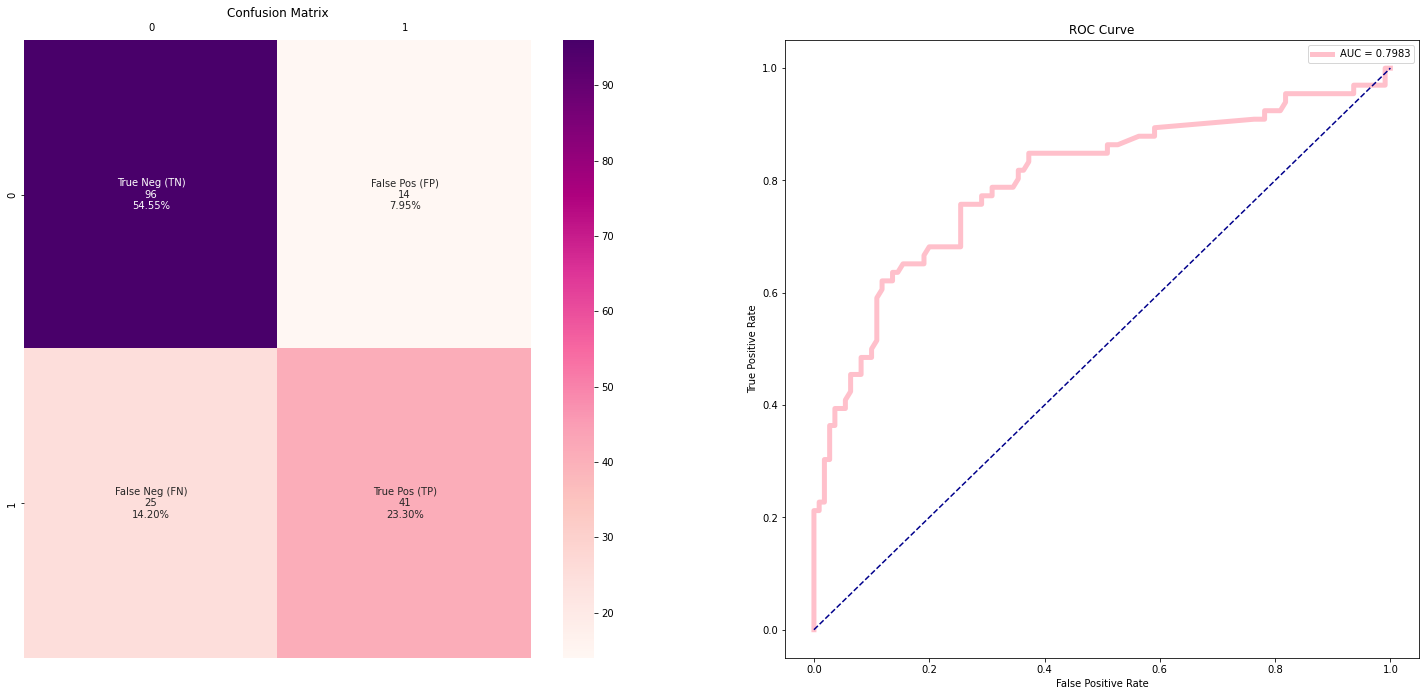

True negative =  96
False positive =  14
False negative =  25
True positive =  41


In [504]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [505]:
comparison_Pclass = comparison_Pclass.append(
    pd.DataFrame(
        {
         "Modele": "Without_PClass - XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [506]:
comparison_Pclass

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - XGBC,0.823864,0.852066,0.712121,0.752000,47,0.796610,19,0.002130
2,Without_PClass - XGBC,0.778409,0.798278,0.621212,0.677686,41,0.745455,25,0.002196


On peut voir que si la Class du passager est supprimé de la prédiction, le modèleest moins performant, il faut donc avoir cette données.

In [507]:
comparison_Pclass.to_csv("comparison_Pclass.csv", index=False)

## <font color='green'>Rôle du Nombre de frères et sœurs / conjoints à bord du Titanic dans la prédiction de la survie : Modèle plus performant sans cette variable</font>

In [508]:
comparison_nbSiSp = pd.DataFrame({})

comparison_nbSiSp = comparison_nbSiSp.append(
    pd.DataFrame(
        {
         "Modele": "All_cols - XGBC",
         "Accuracy": 0.823864,
         "AUC": 0.852066,
         "Recall class 1":0.712121,
         "F1":0.752000,   
         "TP":47,
         "Precision":0.796610,
         "FN":19,
         "time": 0.002130
        },
        index=[1],
    )
)

In [509]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'	   comparison_Pclass.csv   prediction.csv
 comparison_age.csv	   finalized_model.sav	   test_cleaned.csv
 comparison_baseline.csv   gender_submission.csv   train_cleaned.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [510]:
X = train.drop(['Survived', 'nbSiSp'],axis=1)
Y = train['Survived']

In [511]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [512]:
train_index = X_train.index
test_index = X_test.index

In [513]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [514]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [515]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_nbSiSp - XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.203787
1            249              0.128934
2            800              0.474239
3            319              0.988088
4            217              0.714862
..           ...                   ...
171          587              0.033335
172          241              0.753079
173          487              0.996483
174          354              0.189455
175           82              0.253917

[176 rows x 2 columns]
Qua

In [516]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),100 (TN),10 (FP)
Real Positive (1),19 (FN),47 (TP)


In [517]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8439
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       110
           1       0.82      0.71      0.76        66

    accuracy                           0.84       176
   macro avg       0.83      0.81      0.82       176
weighted avg       0.83      0.84      0.83       176



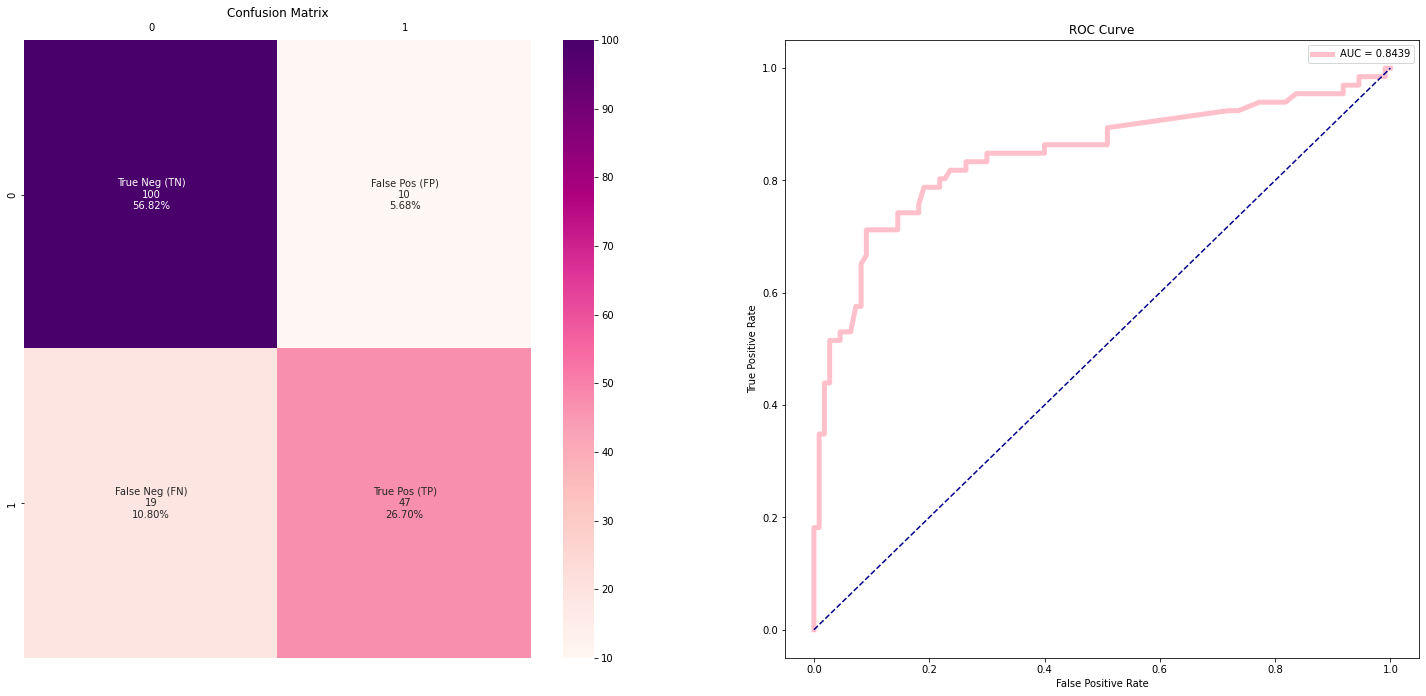

True negative =  100
False positive =  10
False negative =  19
True positive =  47


In [518]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [519]:
comparison_nbSiSp = comparison_nbSiSp.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSiSp - XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [520]:
comparison_nbSiSp

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,All_cols - XGBC,0.823864,0.852066,0.712121,0.752000,47,0.796610,19,0.002130
2,Without_nbSiSp - XGBC,0.835227,0.843871,0.712121,0.764228,47,0.824561,19,0.001914


On peut voir que si le nombre de frères et sœurs / conjoints à bord du Titanic du passager est supprimé de la prédiction, le modèle est plus performant, il n'est pas nécessaire d'avoir cette données.

In [521]:
comparison_nbSiSp.to_csv("comparison_nbSiSp.csv", index=False)

## <font color='green'>Rôle du Nombre de parents / enfants à bord du Titanic dans la prédiction de la survie : Modèle moins performant sans cette variable</font>

In [522]:
comparison_nbParents_child	= pd.DataFrame({})

comparison_nbParents_child = comparison_nbParents_child	.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSiSp - XGBC",
         "Accuracy": 0.835227	,
         "AUC": 0.843871,
         "Recall class 1":0.712121,
         "F1":0.764228,   
         "TP":47,
         "Precision":0.824561,
         "FN":19,
         "time": 0.001941
        },
        index=[1],
    )
)

In [523]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'	   comparison_Pclass.csv   test_cleaned.csv
 comparison_age.csv	   finalized_model.sav	   train_cleaned.csv
 comparison_baseline.csv   gender_submission.csv
 comparison_nbSiSp.csv	   prediction.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [524]:
X = train.drop(['Survived', 'nbSiSp', 'nbParents_child'],axis=1)
Y = train['Survived']

In [525]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [526]:
train_index = X_train.index
test_index = X_test.index

In [527]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [528]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [529]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_nbSip_nbParents_child	 - XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           1
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.125242
1            249              0.259248
2            800              0.516228
3            319              0.987631
4            217              0.693057
..           ...                   ...
171          587              0.031573
172          241              0.570060
173          487              0.996099
174          354              0.182535
175           82              0.257171

[176 rows x 2 columns]
Qua

In [530]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),97 (TN),13 (FP)
Real Positive (1),21 (FN),45 (TP)


In [531]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8522
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        66

    accuracy                           0.81       176
   macro avg       0.80      0.78      0.79       176
weighted avg       0.80      0.81      0.80       176



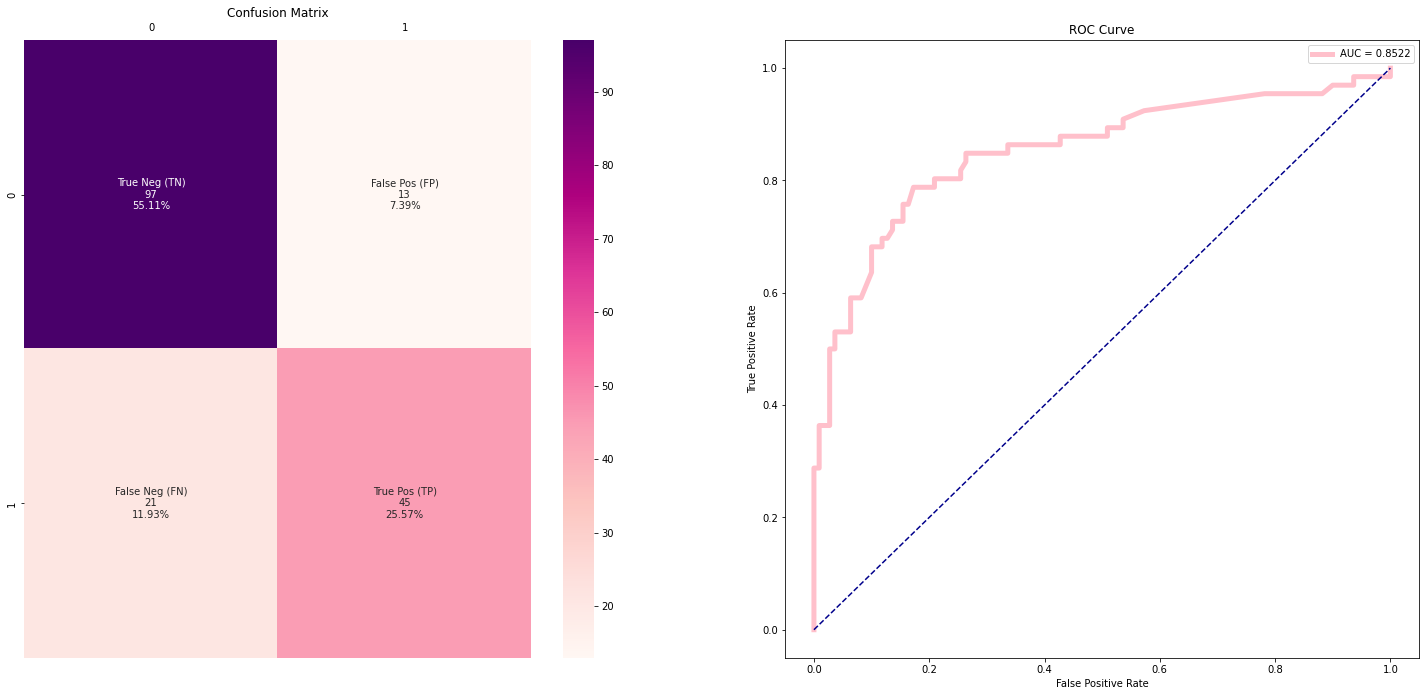

True negative =  97
False positive =  13
False negative =  21
True positive =  45


In [532]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [533]:
comparison_nbParents_child	 = comparison_nbParents_child	.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSiSp_nbParents_child	- XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [534]:
comparison_nbParents_child	

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,Without_nbSiSp - XGBC,0.835227,0.843871,0.712121,0.764228,47,0.824561,19,0.001941
2,Without_nbSiSp_nbParents_child\t- XGBC,0.806818,0.852204,0.681818,0.725806,45,0.775862,21,0.001859


On peut voir que si le Nombre de parents / enfants à bord du Titanic du passager est supprimé de la prédiction, le modèle est moins performant, il est  nécessaire d'avoir cette données.

In [535]:
comparison_nbParents_child.to_csv("comparison_nbParents_child.csv", index=False)

## <font color='green'>Rôle du Sex du passager dans la prédiction de la survie : Modèle moins performant sans cette variable</font>

In [536]:
comparison_Sex_male	= pd.DataFrame({})

comparison_Sex_male = comparison_Sex_male.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSiSp - XGBC",
         "Accuracy": 0.835227	,
         "AUC": 0.843871,
         "Recall class 1":0.712121,
         "F1":0.764228,   
         "TP":47,
         "Precision":0.824561,
         "FN":19,
         "time": 0.001941
        },
        index=[1],
    )
)

In [537]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'		  comparison_nbSiSp.csv   prediction.csv
 comparison_age.csv		  comparison_Pclass.csv   test_cleaned.csv
 comparison_baseline.csv	  finalized_model.sav	  train_cleaned.csv
 comparison_nbParents_child.csv   gender_submission.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [538]:
X = train.drop(['Survived', 'nbSiSp', 'Sex_male'],axis=1)
Y = train['Survived']

In [539]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [540]:
train_index = X_train.index
test_index = X_test.index

In [541]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [542]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [543]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_nbSip_Sex_male- XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.158927
1            249              0.111320
2            800              0.441395
3            319              0.980950
4            217              0.733304
..           ...                   ...
171          587              0.034396
172          241              0.749853
173          487              0.997729
174          354              0.174746
175           82              0.247720

[176 rows x 2 columns]
Qua

In [544]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),99 (TN),11 (FP)
Real Positive (1),21 (FN),45 (TP)


In [545]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8406
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.80      0.68      0.74        66

    accuracy                           0.82       176
   macro avg       0.81      0.79      0.80       176
weighted avg       0.82      0.82      0.81       176



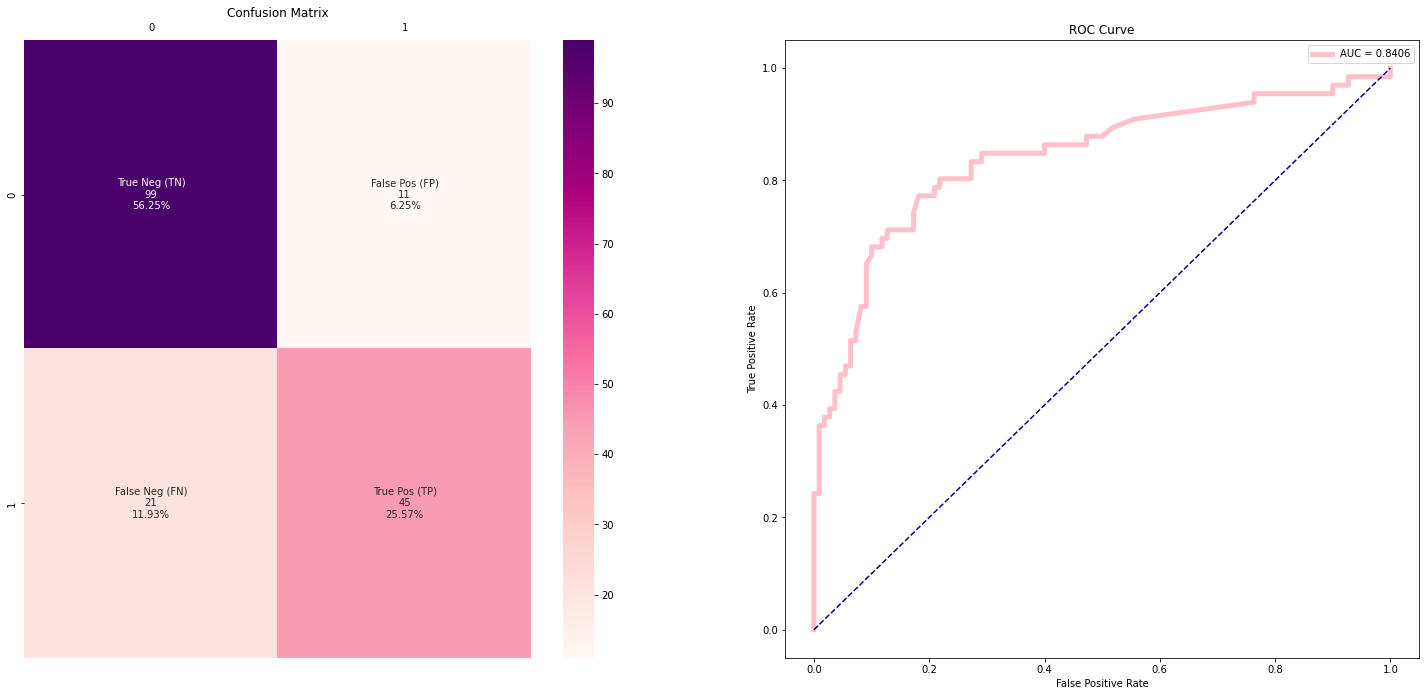

True negative =  99
False positive =  11
False negative =  21
True positive =  45


In [546]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [547]:
comparison_Sex_male	 = comparison_Sex_male.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSip_Sex_male- XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [548]:
comparison_Sex_male	

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,Without_nbSiSp - XGBC,0.835227,0.843871,0.712121,0.764228,47,0.824561,19,0.001941
2,Without_nbSip_Sex_male- XGBC,0.818182,0.840634,0.681818,0.737705,45,0.803571,21,0.001812


On peut voir que si le Sex du passager est supprimé de la prédiction, le modèle est moins performant, il est nécessaire d'avoir cette données.

In [549]:
comparison_Sex_male.to_csv("comparison_Sex_male.csv", index=False)

## <font color='green'>Rôle du titre du passager dans la prédiction de la survie : Modèle moins performant sans cette variable</font>

In [550]:
comparison_Title	= pd.DataFrame({})

comparison_Title = comparison_Title.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSiSp - XGBC",
         "Accuracy": 0.835227	,
         "AUC": 0.843871,
         "Recall class 1":0.712121,
         "F1":0.764228,   
         "TP":47,
         "Precision":0.824561,
         "FN":19,
         "time": 0.001941
        },
        index=[1],
    )
)

In [551]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'		  comparison_Sex_male.csv
 comparison_age.csv		  finalized_model.sav
 comparison_baseline.csv	  gender_submission.csv
 comparison_nbParents_child.csv   prediction.csv
 comparison_nbSiSp.csv		  test_cleaned.csv
 comparison_Pclass.csv		  train_cleaned.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [552]:
X = train.drop(['Survived', 'nbSiSp', 'Title_Kid', 'Title_Miss', 'Title_Mme', 'Title_Mr', 'Title_Officer', 'Title_Royalty'],axis=1)
Y = train['Survived']

In [553]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [554]:
train_index = X_train.index
test_index = X_test.index

In [555]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [556]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [557]:
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(
    XGBC, X_train, y_train, X_test, y_test, "Without_nbSip_Title- XGBC", test_index, file_name=None)

Exécution 
 
     PassengerId  cat_reel  cat_predit
0            334         0           0
1            249         1           0
2            800         0           0
3            319         1           1
4            217         1           1
..           ...       ...         ...
171          587         0           0
172          241         0           1
173          487         1           1
174          354         0           0
175           82         1           0

[176 rows x 3 columns]
     PassengerId  positive_probability
0            334              0.239436
1            249              0.137516
2            800              0.422889
3            319              0.993275
4            217              0.624370
..           ...                   ...
171          587              0.032303
172          241              0.739637
173          487              0.995489
174          354              0.200413
175           82              0.228862

[176 rows x 2 columns]
Qua

In [558]:
df_matrice_confusion = matrix_TN_FN(y_test, prediction)
df_matrice_confusion

,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),96 (TN),14 (FP)
Real Positive (1),18 (FN),48 (TP)


In [559]:
roc_auc = roc_auc_score(y_test, probability[:,1])  #on se base sur la probabilité d'être 1
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, prediction))

AUC : 0.8477
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.77      0.73      0.75        66

    accuracy                           0.82       176
   macro avg       0.81      0.80      0.80       176
weighted avg       0.82      0.82      0.82       176



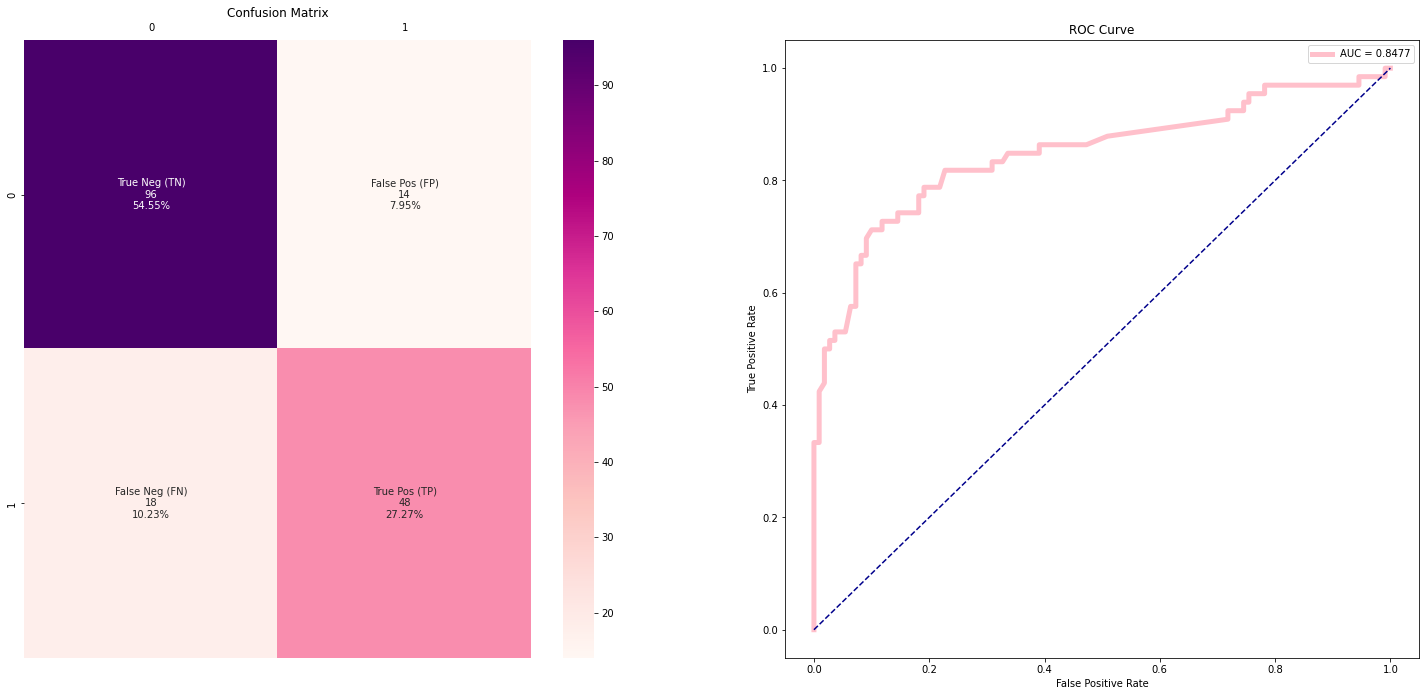

True negative =  96
False positive =  14
False negative =  18
True positive =  48


In [560]:
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25,25))

In [561]:
comparison_Title	 = comparison_Title.append(
    pd.DataFrame(
        {
         "Modele": "Without_nbSip_Title - XGBC",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "time": prediction_time
        },
        index=[2],
    )
)

In [562]:
comparison_Title

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,time
1,Without_nbSiSp - XGBC,0.835227,0.843871,0.712121,0.764228,47,0.824561,19,0.001941
2,Without_nbSip_Title - XGBC,0.818182,0.847658,0.727273,0.750000,48,0.774194,18,0.002500


On peut voir que si le titre du passager est supprimé de la prédiction, le modèle est moins performant, il est nécessaire d'avoir cette données.

In [563]:
comparison_Title.to_csv("comparison_Title.csv", index=False)

## <font color='green'>Prédiction de la survie</font>

In [584]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

train= pd.read_csv('/content/drive/MyDrive/train_cleaned.csv')
train = train.set_index("PassengerId")
train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'		  comparison_Pclass.csv     prediction.csv
 comparison_age.csv		  comparison_Sex_male.csv   test_cleaned.csv
 comparison_baseline.csv	  comparison_Title.csv	    train_cleaned.csv
 comparison_nbParents_child.csv   finalized_model.sav
 comparison_nbSiSp.csv		  gender_submission.csv


,Survived,Pclass,Age,nbSiSp,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1.0,0.0,1,0,0,0,1,0,0
2,1,1,38.0,1.0,0.0,0,0,0,1,0,0,0
3,1,3,26.0,0.0,0.0,0,0,1,0,0,0,0
4,1,1,35.0,1.0,0.0,0,0,0,1,0,0,0
5,0,3,35.0,0.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,0.0,0.0,1,0,0,0,0,0,1
888,1,1,19.0,0.0,0.0,0,0,1,0,0,0,0
889,0,3,16.1,1.0,2.0,0,0,1,0,0,0,0


In [585]:
import pickle

In [586]:
X = train.drop(['Survived', 'nbSiSp'],axis=1)
Y = train['Survived']

In [587]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42 )

In [588]:
X_train

,Pclass,Age,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,
293,2,36.0,0.0,1,0,0,0,1,0,0
694,3,25.0,0.0,1,0,0,0,1,0,0
553,3,28.7,0.0,1,0,0,0,1,0,0
846,3,42.0,0.0,1,0,0,0,1,0,0
809,2,39.0,0.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
108,3,28.7,0.0,1,0,0,0,1,0,0
273,2,41.0,1.0,0,0,0,1,0,0,0
872,1,47.0,1.0,0,0,0,1,0,0,0


In [589]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

test= pd.read_csv('/content/drive/MyDrive/test_cleaned.csv')
test = test.set_index("PassengerId")
test.drop(['nbSiSp'],axis=1, inplace=True)
test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'		  comparison_Pclass.csv     prediction.csv
 comparison_age.csv		  comparison_Sex_male.csv   test_cleaned.csv
 comparison_baseline.csv	  comparison_Title.csv	    train_cleaned.csv
 comparison_nbParents_child.csv   finalized_model.sav
 comparison_nbSiSp.csv		  gender_submission.csv


,Pclass,Age,nbParents_child,Sex_male,Title_Kid,Title_Miss,Title_Mme,Title_Mr,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,
892,3,34.5,0,1,0,0,0,1,0,0
893,3,47.0,0,0,0,0,1,0,0,0
894,2,62.0,0,1,0,0,0,1,0,0
895,3,27.0,0,1,0,0,0,1,0,0
896,3,22.0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1305,3,27.2,0,1,0,0,0,1,0,0
1306,1,39.0,0,0,0,0,0,0,0,1
1307,3,38.5,0,1,0,0,0,1,0,0


In [590]:
train_index = X_train.index
test_index = test.index

In [591]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
test = scaler.transform(test)

In [592]:
XGBC = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=1, n_estimators=100, nthread=-1,
    reg_alpha=0, reg_lambda=1, objective='binary:logistic',
       scale_pos_weight=1, seed=0, subsample=1, use_label_encoder=False, eval_metric='mlogloss')
            

#= {'n_estimators': [400, 700, 1000],
#    'colsample_bytree': [0.7, 0.8],
#    'max_depth': [15,20,25],
#    'reg_alpha': [1.1, 1.2, 1.3],
#    'reg_lambda': [1.1, 1.2, 1.3],
#    'subsample': [0.7, 0.8, 0.9]}

In [593]:
XGBC.fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(XGBC, open(filename, 'wb'))

In [594]:
loaded_model = pickle.load(open(filename, 'rb'))

# Pour avoir la classe prédite 0 si proba <0,5 ; ou 1 si proba >0,5
predict = loaded_model.predict(test)
# Pour avoir la probabilité de prédiction des classes si on veut personnalisé le seuil de classification : exemple avec la création d'un score spécifique
#predict = loaded_model.predict_proba(X)[:, 1]

#print(predict)

In [595]:
prediction_finale	= pd.DataFrame({})

prediction_finale = prediction_finale.append(
    pd.DataFrame(
        {
         "PassengerId" : test_index,
         "Survived_predicted" : predict
        },
    )
)

In [596]:
prediction_finale

,PassengerId,Survived_predicted
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [597]:
prediction_finale.to_csv("prediction.csv", index=False)

In [598]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

real= pd.read_csv('/content/drive/MyDrive/gender_submission.csv')
real

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
'Colab Notebooks'		  comparison_Pclass.csv     prediction.csv
 comparison_age.csv		  comparison_Sex_male.csv   test_cleaned.csv
 comparison_baseline.csv	  comparison_Title.csv	    train_cleaned.csv
 comparison_nbParents_child.csv   finalized_model.sav
 comparison_nbSiSp.csv		  gender_submission.csv


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [599]:
prediction_finale

,PassengerId,Survived_predicted
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [600]:
result = pd.concat([real, prediction_finale["Survived_predicted"]], axis=1)

In [601]:
result

,PassengerId,Survived,Survived_predicted
0,892,0,0
1,893,1,0
2,894,0,0
3,895,0,0
4,896,1,1
...,...,...,...
413,1305,0,0
414,1306,1,1
415,1307,0,0
416,1308,0,0


In [603]:
accuracy = accuracy_score(result['Survived'], result['Survived_predicted'])
accuracy

0.8421052631578947

84% des prédictions sont correctes

## <font color='green'>Cross Val</font>

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors': np.arange(0, 20, 1)} 

# Choisir un score à optimiser
score = 'accuracy'


# define the model/ estimator
model = KNeighborsClassifier()

# define the grid search
# cv : number of cross validation RandomizedSearchCV
rf = GridSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=2)

# Optimiser ce régresseur sur le jeu d'entraînement
rf.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = rf.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (accuracy):")
print(rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'n_neighbors': 18}
 
Meilleur(s) score sur le jeu d'entraînement (accuracy):
0.8337993920972643


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expecte

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_estimators':  np.arange(0, 200, 10),  # nombre d'arbres de décision
              # nombre maximum de niveaux dans chaque arbre de décision
              'max_depth': np.arange(1, 100, 10),
              # nombre minimal d'observation pour créer une feuille
              'min_samples_leaf': np.arange(1, 11, 2),
              'min_samples_split': np.arange(1, 11, 2)}  # nombre minimal d'observation avant séparation du noeud

# Choisir un score à optimiser
score = 'accuracy'


# define the model/ estimator
model = RandomForestClassifier(random_state=42)

# define the grid search
# cv : number of cross validation RandomizedSearchCV

#rf = RandomizedSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=2)

rf = GridSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=2)

# Optimiser ce régresseur sur le jeu d'entraînement
rf.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = rf.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (accuracy):")
print(rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 21}
 
Meilleur(s) score sur le jeu d'entraînement (accuracy):
0.8309726443768998


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'kernel': ['rbf', 'linear', 'sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C' : np.arange(0.01, 1, 0.01)}   

# Choisir un score à optimiser
score = 'accuracy'


# define the model/ estimator
model = SVC()

# define the grid search
rf= GridSearchCV(model, param_grid, scoring=score, cv=5, error_score = 0, verbose = 3, n_jobs = -1)  #, n_jobs = -1 cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
rf.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = rf.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (accuracy):")
print(rf.best_score_)

Fitting 5 folds for each of 1188 candidates, totalling 5940 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.53, 'gamma': 0.01, 'kernel': 'linear'}
 
Meilleur(s) score sur le jeu d'entraînement (accuracy):
0.8309726443768997


In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_estimators': [400, 700, 1000], #np.arange(500, 1000, 100),
              'learning_rate' : [1, 0.1, 0.01, 0.001],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15,20,25],
              'num_leaves': [50, 100, 200],
              'reg_alpha': [1.1, 1.2, 1.3],
              'reg_lambda': [1.1, 1.2, 1.3],
              'min_split_gain': [0.3, 0.4],
              'subsample': [0.7, 0.8, 0.9],
              'subsample_freq': [20]}




# Choisir un score à optimiser
score = 'accuracy'


# define the model/ estimator
model = LGBMClassifier(objective="binary") #or multiclass

# define the grid search
#lgbm, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 #param_grid, cv=5, scoring_fit='accuracy')



# Optimiser ce régresseur sur le jeu d'entraînement
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV                    
#lgbm= RandomizedSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV                    
lgbm.fit(X_train, y_train, eval_metric='accuracy')


# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (accuracy):")
print(lgbm.best_score_)




Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.1, 'reg_alpha': 1.3, 'num_leaves': 200, 'n_estimators': 400, 'min_split_gain': 0.3, 'max_depth': 25, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
 
Meilleur(s) score sur le jeu d'entraînement (accuracy):
0.8380749746707193


In [120]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_estimators' : np.arange(0, 500, 100),  #nombre d'arbres de décision #(10,100,10). [100, 500, 1000, 1500, 2000]
              'max_depth': np.arange(0, 50, 10) }#nombre maximum de niveaux dans chaque arbre de décision    

              #'n_estimators':  np.arange(50, 300, 20),  #nombre d'arbres de décision #(10,100,10)
              #'max_depth': np.arange(20, 50, 5)

# Choisir un score à optimiser
score = 'accuracy'


# define the model/ estimator
model = XGBClassifier(objective= 'binary:logistic', random_state=42) #or multi:softprob

# define the grid search
rf= GridSearchCV(model, param_grid, scoring=score, cv=5, n_jobs=-1, verbose=3)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
rf.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = rf.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (accuracy):")
print(rf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'max_depth': 10, 'n_estimators': 100}
 
Meilleur(s) score sur le jeu d'entraînement (accuracy):
0.8252684903748733
